In [48]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn  # nn stands for neural network
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [50]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [51]:
data_df.dropna(inplace=True)  # remove the missing values and make changes in original datasets.
data_df.drop(['id'], axis=1, inplace=True) # axis = 1 means its a column
print(data_df.shape)


(18185, 11)


In [52]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [53]:
# printing the total 1 and 0 in Class column for output y
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [54]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [55]:
X = np.array(data_df.iloc[:,:-1]) # all the rows and columns(expect last one)
y = np.array(data_df.iloc[:,-1]) # column only the last one

In [56]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3)
X_test , X_validation , y_test , y_validation = train_test_split(X_test,y_test,test_size=0.5)


In [57]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [58]:
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(12729,)
(2728,)
(2728,)


In [59]:
# converting numpy arrays into PyTorch tensors

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
X_validation = torch.from_numpy(X_validation)
y_validation = torch.from_numpy(y_validation)


X_train = X_train.float()
X_test = X_test.float()
X_validation = X_validation.float()
y_train = y_train.float()
y_test = y_test.float()
y_validation = y_validation.float()

In [60]:
class CustomDataset(Dataset):
  def __init__(self,X,y): # X = input , y = output
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index],self.y[index]

In [61]:
# creating objects of CustomDataset class and it will automatically call the constructor that is __init__ method
training_data = CustomDataset(X_train,y_train)
validation_data = CustomDataset(X_validation,y_validation)
testing_data = CustomDataset(X_test,y_test)

In [62]:
# now we will put all these dataset into the dataloader class for creating mini-batches and then process them further
# that is DataLoader(Dataset)

training_dataloader = DataLoader(training_data,batch_size=8,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=8,shuffle=True)
testing_dataloader = DataLoader(testing_data,batch_size=8,shuffle=True)

In [63]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(X.shape[1],10)   # X.shape[1] = means 10 columns , hidden layer-1 = 10 neurons
    self.linear = nn.Linear(10,1)  # 1=output layer and 10 neurons=hidden layer
    self.sigmoid = nn.Sigmoid() # output value should be 1 or 0

  def forward(self,x):  # this is forward propogation
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)


In [64]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [65]:
criterion = nn.BCELoss()  # define loss function
optimizer = Adam(model.parameters(),lr=0.001) # define the optimizer
epochs = 10 # no of times we need to run out model and train it

In [68]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

for epoch in range(epochs):
  total_loss_train = 0
  total_loss_validation = 0
  total_accuracy_train = 0
  total_accuracy_validation = 0

  for data in training_dataloader:
    inputs, outputs = data
    # move both to device (GPU or CPU)
    inputs, outputs = inputs.to(device), outputs.to(device)
    # we will put the inputs in the model
    prediction = model(inputs).squeeze(1)
    # now we will calculate the loss ( BCELOSS) we have defined in the above cell
    batch_loss = criterion(prediction,outputs)
    # now we will put this batch_loss values of each epoch in total_loss_train
    total_loss_train += batch_loss.item()

    # now we will find the accuracy on the training data and store the values in total_accuracy_train
    acc = (prediction.round() == outputs).sum().item()
    total_accuracy_train += acc

    # now we will do backpropogation
    batch_loss.backward()
    # for this we will need optimzer to update the old weights to new weights
    optimizer.step()
    # we also need to clear the old gradients and set it to 0
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs , outputs = data
      inputs, outputs = inputs.to(device), outputs.to(device)
      prediction = model(inputs).squeeze(1) # Added .squeeze(1) here
      batch_loss = criterion(prediction,outputs)
      total_loss_validation += batch_loss.item()
      acc = (prediction.round() == outputs).sum().item()
      total_accuracy_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000,4)) # round off till 4 numbers
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_accuracy_train_plot.append(round(total_accuracy_train/training_data.__len__() * 100,4))
  total_accuracy_validation_plot.append(round(total_accuracy_validation/validation_data.__len__() * 100,4))

  print(f'''Epoch number {epoch+1} Training Loss: {round(total_loss_train/1000,4)} Training Accuracy: {round(total_accuracy_train/training_data.__len__() * 100,4)}
            Validation Loss: {round(total_loss_validation/1000,4)}  Validation Accuracy: {round(total_accuracy_validation/validation_data.__len__() * 100,4)}''') # as epoch index starts from 0 so epoch+1 means 0+1=1
  print("="*25)

Epoch number 1 Training Loss: 0.1368 Training Accuracy: 98.4288
        Validation Loss: 0.0219  Validation Accuracy: 98.0572
Epoch number 2 Training Loss: 0.0855 Training Accuracy: 98.5073
        Validation Loss: 0.0169  Validation Accuracy: 98.3504
Epoch number 3 Training Loss: 0.0742 Training Accuracy: 98.5231
        Validation Loss: 0.0155  Validation Accuracy: 98.3504
Epoch number 4 Training Loss: 0.0697 Training Accuracy: 98.5781
        Validation Loss: 0.0153  Validation Accuracy: 98.3504
Epoch number 5 Training Loss: 0.0683 Training Accuracy: 98.5466
        Validation Loss: 0.0151  Validation Accuracy: 98.3504
Epoch number 6 Training Loss: 0.0663 Training Accuracy: 98.5388
        Validation Loss: 0.0146  Validation Accuracy: 98.4604
Epoch number 7 Training Loss: 0.0667 Training Accuracy: 98.5702
        Validation Loss: 0.0148  Validation Accuracy: 98.4238
Epoch number 8 Training Loss: 0.0659 Training Accuracy: 98.5781
        Validation Loss: 0.0143  Validation Accuracy: 

In [71]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, outputs = data
    inputs, outputs = inputs.to(device), outputs.to(device)
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), outputs)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == outputs).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")


Accuracy Score is: 98.39%


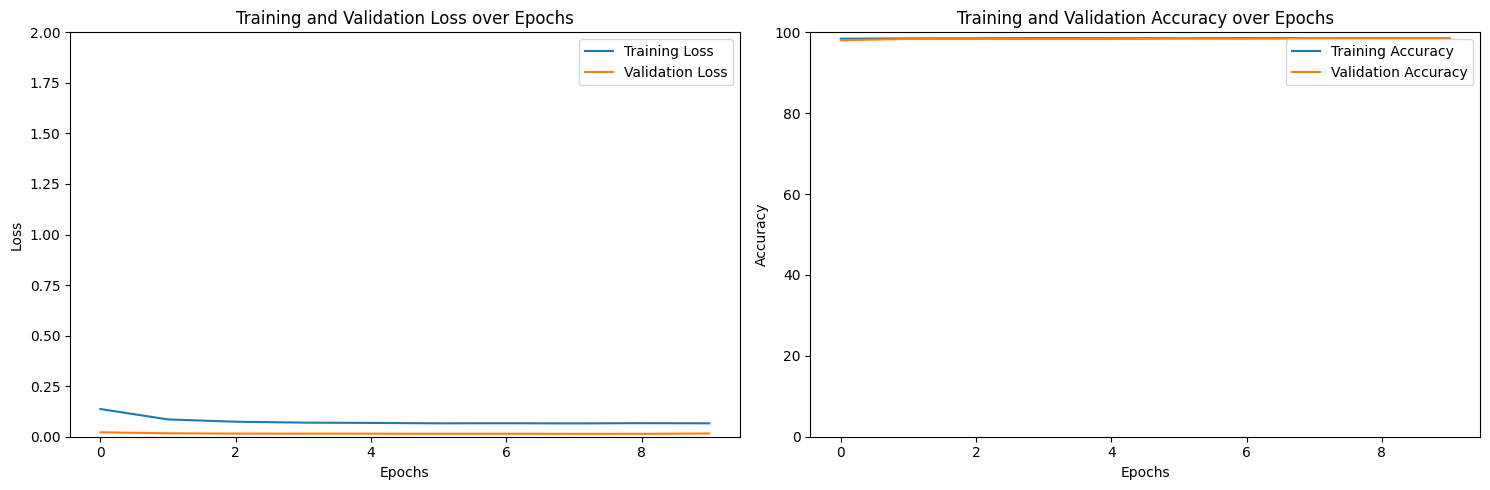

In [73]:
# plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_accuracy_train_plot, label='Training Accuracy')
axs[1].plot(total_accuracy_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [74]:
model.eval()
with torch.no_grad():
    all_predictions = []
    for data in testing_dataloader:
        inputs, _ = data
        inputs = inputs.to(device)
        preds = model(inputs).squeeze(1)
        preds = (preds >= 0.5).int()   # convert probs to 0 or 1
        all_predictions.extend(preds.cpu().numpy())

print(pd.Series(all_predictions).value_counts())


1    1509
0    1219
Name: count, dtype: int64
